# Car Price prediction


## Прогнозирование стоимости автомобиля по характеристикам
*Этот ноутбук является шаблоном (Baseline) к текущему соревнованию и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

## EDA

In [1]:

import pandas as pd # импортируем необходимые библиотеки
import numpy as np
import re
import random
import os
import sys
import PIL
#import cv2

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import ExtraTreeRegressor
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler 

from catboost import CatBoostRegressor

from tqdm import tqdm
from tqdm.notebook import tqdm

from itertools import combinations
from scipy.stats import ttest_ind


# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
#import albumentations

import nltk
from nltk.corpus import stopwords

# plt
import matplotlib.pyplot as plt
import seaborn as sns
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

In [2]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
Numpy        : 1.16.5
Tensorflow   : 2.3.1


# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [3]:
# Загрузим данные

DATA_DIR = 'C:/Users/79265/Downloads/batmob/' # '../input/sf-dst-car-price-prediction-part2/'
train1 = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [4]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет

train1['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

train = test.append(train1, sort=False).reset_index(drop=True) # объединяем
print(train1.shape, test.shape, train.shape)

(6682, 23) (1671, 23) (8353, 23)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 23 columns):
bodyType                8353 non-null object
brand                   8353 non-null object
color                   8353 non-null object
description             8353 non-null object
engineDisplacement      8353 non-null object
enginePower             8353 non-null object
fuelType                8353 non-null object
mileage                 8353 non-null int64
modelDate               8353 non-null int64
model_info              8353 non-null object
name                    8353 non-null object
numberOfDoors           8353 non-null int64
productionDate          8353 non-null int64
sell_id                 8353 non-null int64
vehicleConfiguration    8353 non-null object
vehicleTransmission     8353 non-null object
Владельцы               8352 non-null object
Владение                2935 non-null object
ПТС                     8353 non-null object
Привод                  8353 non-null objec

In [6]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             7654
engineDisplacement        48
enginePower              154
fuelType                   4
mileage                 3507
modelDate                 43
model_info               122
name                     976
numberOfDoors              4
productionDate            39
sell_id                 8353
vehicleConfiguration     312
vehicleTransmission        4
Владельцы                  3
Владение                 180
ПТС                        2
Привод                     3
Руль                       2
sample                     2
price                   1629
dtype: int64

In [7]:
train.isnull().sum()

bodyType                   0
brand                      0
color                      0
description                0
engineDisplacement         0
enginePower                0
fuelType                   0
mileage                    0
modelDate                  0
model_info                 0
name                       0
numberOfDoors              0
productionDate             0
sell_id                    0
vehicleConfiguration       0
vehicleTransmission        0
Владельцы                  1
Владение                5418
ПТС                        0
Привод                     0
Руль                       0
sample                     0
price                      0
dtype: int64

In [8]:
# Посмотрим %-ое соотношение пропусков

train1.isnull().sum()[train.isnull().sum() >0] /8353*100

Владельцы     0.011972
Владение     51.789776
dtype: float64

In [9]:
train

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price
0,универсал 5 дв.,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3.0 LTR,220 N12,бензин,350000,1984,W124,...,1099427284,WAGON_5_DOORS AUTOMATIC 3.0,автоматическая,3 или более,6 лет и 3 месяца,Оригинал,задний,Левый,0,0.0
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3.0 LTR,313 N12,дизель,15000,2011,6ER,...,1096405886,COUPE AUTOMATIC 3.0,автоматическая,1 владелец,6 лет и 6 месяцев,Оригинал,полный,Левый,0,0.0
2,купе,BMW,пурпурный,"Машина тут продаётся не в первый раз, НО! Толь...",2.5 LTR,218 N12,бензин,166600,2005,3ER,...,1100195294,COUPE AUTOMATIC 2.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый,0,0.0
3,седан,BMW,белый,"Автомобиль в отличном состоянии, весь в родной...",2.0 LTR,136 N12,бензин,147000,2005,3ER,...,1099827282,SEDAN AUTOMATIC 2.0,автоматическая,2 владельца,NaN,Оригинал,задний,Левый,0,0.0
4,седан,BMW,чёрный,Немка! с бесключивым доступом и камерой заднег...,2.0 LTR,190 N12,дизель,24000,2016,5ER,...,1100076198,SEDAN AUTOMATIC 2.0,автоматическая,1 владелец,NaN,Оригинал,полный,Левый,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8348,седан,BMW,серый,Продаётся любимый автомобиль! За годы эксплуат...,2.0 LTR,150 N12,бензин,232777,2005,3ER,...,1100036650,SEDAN AUTOMATIC 2.0,автоматическая,3 или более,NaN,Оригинал,задний,Левый,1,550000.0
8349,седан,BMW,чёрный,Куплена у официального дилера в 2017 г. \n\nТр...,2.0 LTR,190 N12,дизель,33700,2013,5ER,...,1090506038,SEDAN AUTOMATIC 2.0,автоматическая,3 или более,2 года и 2 месяца,Оригинал,задний,Левый,1,1900000.0
8350,седан,BMW,белый,Торг на месте. Все работает. Сборка немецкая. ...,2.0 LTR,143 N12,бензин,200000,2008,3ER,...,1095155628,SEDAN AUTOMATIC 2.0,автоматическая,3 или более,2 года и 2 месяца,Оригинал,задний,Левый,1,530000.0
8351,седан,AUDI,чёрный,Автомобиль в отличном состоянии.\n3-из Авто в ...,3.0 LTR,310 N12,бензин,72000,2013,A8,...,1099625256,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый,1,1970000.0


In [10]:
# Приведем к int

train['engineDisplacement'] = train['engineDisplacement'].apply(lambda s: '0' if (s == 'undefined LTR') else s)
train['engineDisplacement'] = train['engineDisplacement'].str.split(' ').apply(lambda s: int(float(s[0])*10))
#train['engineDisplacement'] = train['engineDisplacement'].apply(lambda s: int(s*10))
train['engineDisplacement'].unique()

array([30, 25, 20, 35, 18, 22, 55, 48, 16, 47, 40, 15, 24, 14, 21, 52, 44,
       28, 42, 32, 60, 37, 50, 12, 36, 23, 62, 17, 13, 54, 31, 26, 38, 41,
       29, 66, 59,  0, 27,  7, 19, 43, 58, 49, 34, 63, 56, 46],
      dtype=int64)

In [11]:
# Заменим на количество лет

train['modelDate']=(2020-train['modelDate'])
train['productionDate']=(2020-train['productionDate'])

In [12]:
# Преобразуем в целое, удалив N12

train['enginePower'] = train['enginePower'].str.split(' ').apply(lambda s: int(s[0]))
train['enginePower'].unique()

array([220, 313, 218, 136, 190, 340, 245, 316, 170, 160, 231, 388, 180,
       367, 115, 184, 177, 455, 422, 163, 249, 272, 224, 122, 557, 333,
       306, 156, 150, 264, 450, 555, 407, 130, 400, 204, 469, 192, 210,
       211, 239, 200, 350, 420, 300, 381, 265, 258, 390, 197, 120, 544,
       193, 235, 233, 394, 355, 421, 320, 585, 105, 280, 194, 132, 639,
       250, 335, 510, 116, 360, 238, 225, 625, 571, 507, 286, 372, 575,
       408, 310, 354, 255, 435, 525, 591, 109, 462, 143, 279, 487, 560,
       125, 609, 102, 290, 296, 230, 326, 269, 445, 580, 370, 401, 129,
       500, 270, 140, 110, 476, 166, 321, 626, 252, 612, 113, 101, 240,
       605, 700, 133,  95, 558, 271,  82, 530, 329, 517, 118, 430, 260,
       550, 299, 610, 402, 330, 600, 292, 431, 520, 100, 242, 457,  75,
       256, 347, 223, 215,  98, 114, 480, 234, 514, 165, 174], dtype=int64)

In [13]:
# СОздадим новый признак "километраж в год"

def round_int(x):
    if x == float("inf") or x == float("-inf") or x == float("nan"):
        return float('nan') # or x or return whatever makes sense
    elif x>0:
        return float(round(x))
    else:
        print(x)
        return str(round(x))

train['mil_year'] = (train['mileage']/train['productionDate'])
train['mil_year'] = train['mil_year'].apply(round_int)
train['mil_year'] = train['mil_year'].fillna(train['mileage'])
train['mil_year'] = train['mil_year'].astype('int32')
train['mil_year'].unique()

array([12069,  2143, 13883, ..., 16627,  8425,   887], dtype=int64)

In [14]:
# Создадим новый признак - количество лощадей на единицу обьема двигателя, электро = 0

train['pow_eng'] = (train['enginePower']/train['engineDisplacement'])
train['pow_eng'] = train['pow_eng'].apply(round_int)
train['pow_eng'] = train['pow_eng'].fillna(0)
train['pow_eng'] = train['pow_eng'].astype('int32')
train['pow_eng'].unique()

array([ 7, 10,  9, 11,  8, 12,  6, 14, 13, 15, 16,  5, 18, 17,  0, 26,  4,
       24, 19,  3], dtype=int64)

In [15]:
train[train['engineDisplacement'] ==0]

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price,mil_year,pow_eng
1005,хэтчбек 5 дв.,BMW,серебристый,.,0,170,электро,89942,7,I3,...,автоматическая,1 владелец,NaN,Оригинал,задний,Левый,0,0.0,14990,0
3967,хэтчбек 5 дв.,BMW,чёрный,"Автомобиль в наличии Москве , с ПТС , производ...",0,184,электро,9000,3,I3,...,автоматическая,1 владелец,NaN,Оригинал,задний,Левый,1,2719000.0,9000,0
5396,хэтчбек 5 дв.,BMW,чёрный,"BMW i3 Электромобиль с бензиновым генератором,...",0,170,электро,39500,3,I3,...,автоматическая,1 владелец,2 года и 11 месяцев,Оригинал,задний,Левый,1,2299711.0,13167,0
5397,хэтчбек 5 дв.,BMW,голубой,Прибыло из Америки в августе 20 года. Полная и...,0,170,электро,28800,3,I3,...,автоматическая,1 владелец,NaN,Оригинал,задний,Левый,1,2170000.0,9600,0
7533,хэтчбек 5 дв.,BMW,белый,В наличии! Автомобиль куплен в США! Комплектац...,0,170,электро,35810,7,I3,...,автоматическая,1 владелец,NaN,Оригинал,задний,Левый,1,1690000.0,8952,0
7954,хэтчбек 5 дв.,BMW,чёрный,Авто в идеальном состоянии\nЕсть REX (range ex...,0,170,электро,60000,7,I3,...,автоматическая,1 владелец,NaN,Оригинал,задний,Левый,1,1790000.0,12000,0


In [16]:
# Преобразуем к целому и заполним пустые значения

train['Владельцы'] = train['Владельцы'].astype('str')
train['Владельцы'] = train['Владельцы'].str.split(' ').apply(lambda s: (s[0].split('\xa0')[0]))
train['Владельцы'] = train['Владельцы'].apply(lambda s: 2 if (s == 'nan') else s)
train['Владельцы'] = train['Владельцы'].astype('int32')

In [17]:
train['Владельцы'].unique()

array([3, 1, 2], dtype=int64)

In [18]:
# Преобразуем в месяцы и заполним пустые значения средним числом владения одиним владельцем столбец Владение

train['Владение'] = train['Владение'].fillna('0 no no 0')
train['Владение_год'] = train['Владение'].str.split(' ').apply(lambda s: (s[0]))
train['Владение_мес'] = train['Владение'].str.split(' ').apply(lambda s: s[3] if len(s)>2 else 0)
train['Владение_мес'] = train['Владение_мес'].astype('int32')

for i in range(0, len(train)):
    if train['Владение_год'][i] == '0':
        train['Владение_год'][i] = int(round((train['productionDate'][i]/train['Владельцы'][i])*12))
    else: 
        train['Владение_год'][i] = int(train['Владение_год'][i]) * 12
        
train['Владение'] = train['Владение_год'] + train['Владение_мес']

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [19]:
# Создадим новый признак - количество лет на одного владельца

train['Owner_year'] = (train['productionDate']/train['Владельцы'])*12
train['Owner_year'] = train['Owner_year'].astype('int32')

In [20]:
train['price'] = train['price'].astype('int32')

In [21]:
def find_drive(s):
    # функция поиска и преобразования значимых частей в названии автомобиля
    
    s = s.lower()
    if s.find('xdrive') != -1 :
        return str('xDrive')
    elif s.find('sdrive') != -1 :
        return str('sDrive')
    elif s.find('cvt') != -1 :
        return str('CVT')
    elif s.find('amt') != -1 :
        return str('AMT')
    elif s.find('at') != -1 :
        return str('AT')
    elif s.find('amg') != -1 :
        return str('AMG')
    elif s.find('bluetec') != -1 :
        return str('BlueTEC')
    elif s.find('hyb') != -1 :
        return str('hyb')
    elif s.find('tronic') != -1 :
        return str('Tronic')
    else: 
        return str('0')

In [22]:
def del_drive(s):
    # функция удаления из названия его частей
    
    s = s.lower()
    if s.find('xdrive') != -1 :
        return s.replace('xdrive', '')
    elif s.find('sdrive') != -1 :
        return s.replace('sdrive', '')
    elif s.find('cvt') != -1 :
        return s.replace('cvt', '')
    elif s.find('hyb') != -1 :
        return s.replace('hyb', '')
    elif s.find('amt') != -1 :
        return s.replace('amt', '')
    elif s.find('at') != -1 :
        return s.replace('at', '')
    elif s.find('amg') != -1 :
        return s.replace('amg', '')
    elif s.find('bluetec') != -1 :
        return s.replace('bluetec', '')
    elif s.find('tronic') != -1 :
        return s.replace('tronic', '')
    else:
        return s

In [23]:
# Из name выделяем 2 категориальные переменные названия авто: название модели и значимая часть в названии типа xDrive

train['name1'] = train['name'].str.split(' ').apply(lambda s: (s[0]).lower())
train['name2'] = train['name'].apply(find_drive)
train['name1'] = train['name1'].apply(del_drive)
#train['name1'] = train['name1']+train['name2']
 

In [24]:
train['name1'].unique()

array(['300', '640d', '325xi', '318i', '520d', '540i', '3.0d', '350',
       '1.8', '320i', '500', '2.0', '650i', '116i', '25d', '20d', '330i',
       '200', '320d', '118i', '30d', '630i', '2.4', '320', '1.4', '428i',
       '63', '400', '2.5', '35i', '180', '18i', '520i', '3.0si', '5.2',
       '4.4', '750i', '528i', '450', '750d', '730ld', '2.8', '560', '20i',
       '30i', '55', '535i', '4.2', '4.0', 'competition', '3.0', 'm50d',
       '250', '730d', '525i', '50i', '43', '530d', '545i', '630d', '328i',
       '120i', '220', '119', '600', '48i', '280', '750li', '1.2', 'l1',
       '3.6', '230', '520li', '740li', '4.8is', '325i', '740i', '525d',
       'm550d', '28i', '4.4i', 'long', '530i', '335i', '523i', '3.1',
       '740d', '420d', 'l2', '550', '645i', '730li', '640i', 'gt', '240',
       '3.0i', '2.0d', '435i', '380', '18d', '4.8i', '45', 'l3', 's',
       's-', '4.1d', '35d', 'm760li', '420i', '420', '316i', '1.6',
       'activerid', '530xi', '40d', '8tip', '335d', '120d', '4

In [25]:
train['name2'].unique()

array(['AT', 'xDrive', 'CVT', 'AMT', '0', 'sDrive'], dtype=object)

In [26]:
# введем новый признак "tax" (расчет годового налога):

train['tax'] = train.enginePower.apply(lambda x: x*12 if x<=100 
                                           else x*25 if x>100 and x<=125
                                           else x*35 if x>125 and x<=150
                                           else x*45 if x>150 and x<=175
                                           else x*55 if x>175 and x<=200
                                           else x*65 if x>200 and x<=225
                                           else x*75 if x>225 and x<=250
                                           else x*150)

In [ ]:
# Сохраним обработанный датасет для последующего его использования в алгоритмах обучения

train.to_csv('train_batmobil8.csv', index=False)

In [27]:
train

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,sample,price,mil_year,pow_eng,Владение_год,Владение_мес,Owner_year,name1,name2,tax
0,универсал 5 дв.,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,30,220,бензин,350000,36,W124,...,0,0,12069,7,72,3,116,300,AT,14300
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,30,313,дизель,15000,9,6ER,...,0,0,2143,10,72,6,84,640d,xDrive,46950
2,купе,BMW,пурпурный,"Машина тут продаётся не в первый раз, НО! Толь...",25,218,бензин,166600,15,3ER,...,0,0,13883,9,48,0,48,325xi,AT,14170
3,седан,BMW,белый,"Автомобиль в отличном состоянии, весь в родной...",20,136,бензин,147000,15,3ER,...,0,0,11308,7,78,0,78,318i,AT,4760
4,седан,BMW,чёрный,Немка! с бесключивым доступом и камерой заднег...,20,190,дизель,24000,4,5ER,...,0,0,24000,10,12,0,12,520d,xDrive,10450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8348,седан,BMW,серый,Продаётся любимый автомобиль! За годы эксплуат...,20,150,бензин,232777,15,3ER,...,1,550000,16627,8,56,0,56,320i,AT,5250
8349,седан,BMW,чёрный,Куплена у официального дилера в 2017 г. \n\nТр...,20,190,дизель,33700,7,5ER,...,1,1900000,8425,10,24,2,16,520d,AT,10450
8350,седан,BMW,белый,Торг на месте. Все работает. Сборка немецкая. ...,20,143,бензин,200000,12,3ER,...,1,530000,16667,7,24,2,48,318i,AT,5005
8351,седан,AUDI,чёрный,Автомобиль в отличном состоянии.\n3-из Авто в ...,30,310,бензин,72000,7,A8,...,1,1970000,18000,10,16,0,16,long,AT,46500


## Анализ на значимость признаков

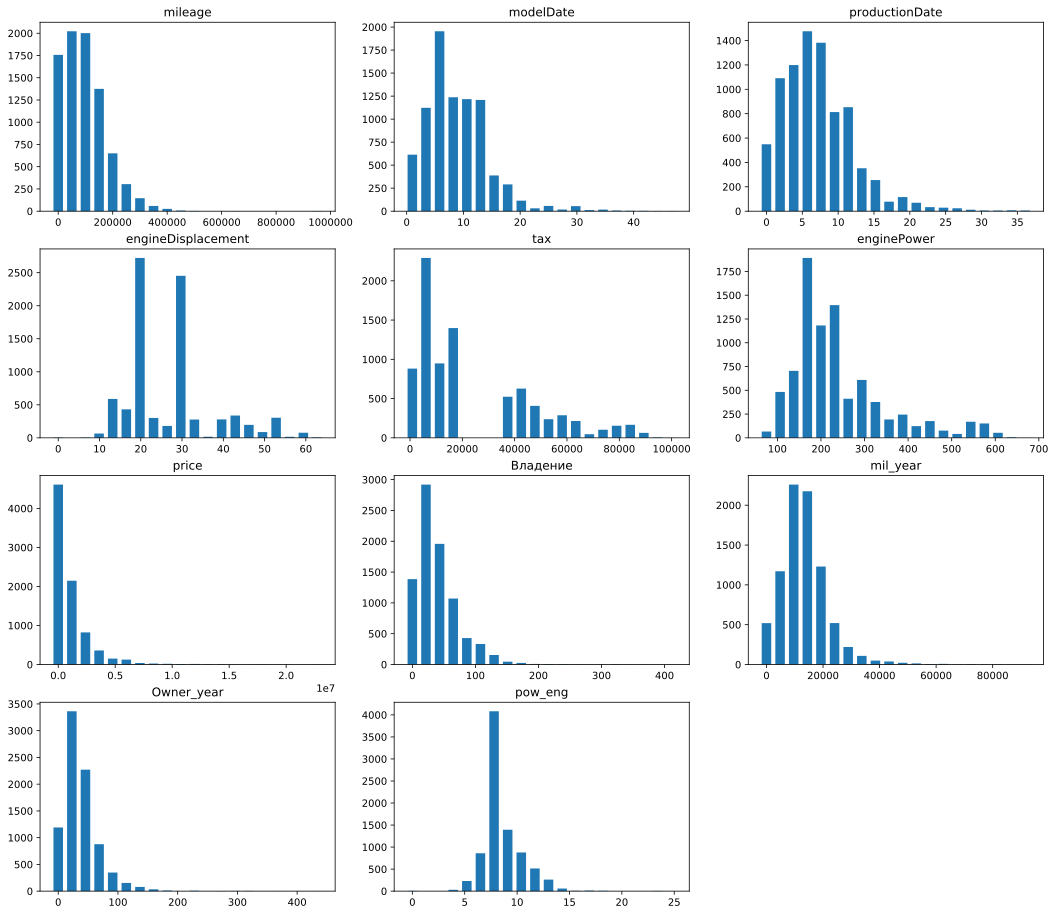

In [32]:
# Посмотрим, как выглядят распределения числовых признаков.

def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna(),
    'engineDisplacement': train['engineDisplacement'].dropna(),
    'tax': train['tax'].dropna(), 
    'enginePower': train['enginePower'].dropna(),
    'price': train['price'].dropna(),
    'Владение': train['Владение'].dropna(),
    'mil_year': train['mil_year'].dropna(),
    'Owner_year': train['Owner_year'].dropna(),
    'pow_eng': train['pow_eng'].dropna()
})

In [28]:
# Проведем тест Стьюдента для определения наиболее значимых для результата признаков 
# Как видим, все категориальные значения, кроме Руль, значимы. Удаляем Руль и name, поскольку дублируется name1 и name2
#from itertools import combinations
#from scipy.stats import ttest_ind

def get_student(column):
# тест Стьюдента

    cols = train.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
#    display (combinations_all)
    for comb in combinations_all:
        if ttest_ind(train.loc[train.loc[:, column] == comb[0], 'price'], 
                        train.loc[train.loc[:, column] == comb[1], 'price']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break
for col in [  'bodyType', 'brand', 'color',  'fuelType', 'model_info', 'name','name1','name2','numberOfDoors',  'vehicleTransmission',
       'Владельцы', 'ПТС', 'Привод', 'Руль']:
    get_student(col)

Найдены статистически значимые различия для колонки bodyType
Найдены статистически значимые различия для колонки brand
Найдены статистически значимые различия для колонки color
Найдены статистически значимые различия для колонки fuelType
Найдены статистически значимые различия для колонки model_info
Найдены статистически значимые различия для колонки name
Найдены статистически значимые различия для колонки name1
Найдены статистически значимые различия для колонки name2
Найдены статистически значимые различия для колонки numberOfDoors
Найдены статистически значимые различия для колонки vehicleTransmission
Найдены статистически значимые различия для колонки Владельцы
Найдены статистически значимые различия для колонки ПТС
Найдены статистически значимые различия для колонки Привод


In [29]:
# По матрице корреляций посмотрим как скоррелированы числовые признаки с целевой переменной и между собой
# Наблюдаем довольно большую корреляцию между годом модели и годом выпуска, что логично. Поэтоу одну из этих дат удалим.
# Остальные признаки (вновь созданные) tax и mil_year, несмотря на корреляцию оставим. как показала практика, они все-таки улучшают рез-т

import seaborn as sns

car_corr = train[[ 'engineDisplacement', 'tax', 'enginePower', 'mileage', 'modelDate', 'price', 'productionDate', 'Владение', 'mil_year','Owner_year', 'pow_eng']]
correlation = car_corr.corr()
cmap = sns.diverging_palette(5, 250, as_cmap=True)

correlation.style.background_gradient(cmap, axis=1)

,engineDisplacement,tax,enginePower,mileage,modelDate,price,productionDate,mil_year,Owner_year,pow_eng
engineDisplacement,1,0.854643,0.859464,0.050115,0.195821,0.240498,0.210305,-0.17935,0.129944,-0.0647815
tax,0.854643,1,0.971642,-0.147756,-0.0533177,0.353413,-0.0342456,-0.19735,-0.038801,0.365543
enginePower,0.859464,0.971642,1,-0.184616,-0.101825,0.404552,-0.0851002,-0.188617,-0.072888,0.401511
mileage,0.050115,-0.147756,-0.184616,1,0.672522,-0.436743,0.70297,0.4026,0.436548,-0.428044
modelDate,0.195821,-0.0533177,-0.101825,0.672522,1,-0.397267,0.964919,-0.136958,0.660284,-0.503087
price,0.240498,0.353413,0.404552,-0.436743,-0.397267,1,-0.417464,-0.158236,-0.282134,0.309535
productionDate,0.210305,-0.0342456,-0.0851002,0.70297,0.964919,-0.417464,1,-0.146048,0.680447,-0.494762
mil_year,-0.17935,-0.19735,-0.188617,0.4026,-0.136958,-0.158236,-0.146048,1,-0.112302,-0.0442115
Owner_year,0.129944,-0.038801,-0.072888,0.436548,0.660284,-0.282134,0.680447,-0.112302,1,-0.347645
pow_eng,-0.0647815,0.365543,0.401511,-0.428044,-0.503087,0.309535,-0.494762,-0.0442115,-0.347645,1


In [10]:
# Удалим явно незначимые столбцы и ненужные на этапе обучения

data = train.copy()

train = train.drop(['vehicleConfiguration', 'sell_id', 'Владение_мес', 'Владение_год', 'Руль', 'modelDate', 'description', 'name'], axis = 1)   
#train = train.drop(['name2'], axis = 1)   